In [23]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import Gate
from qiskit.visualization import plot_distribution

## Oracle

In [2]:
class Oracle(Gate):
    def __init__(self, case, n):
        super().__init__("oracle", n+1, [])  # n+1 qubits, including the auxiliary qubit
        self.case = case
        self.n = n
        self.b_str = None
        if self.case == 'balanced':
            b = np.random.randint(1, 2**self.n)
            self.b_str = f'{b:0{self.n}b}'

    def _define(self):
        qc = QuantumCircuit(self.num_qubits, name=self.name)
        if self.case == 'balanced':
            b_str = self.b_str
            for i in range(len(b_str)):
                if b_str[i] == '1':
                    qc.x(i)
            
            for i in range(len(b_str)):
                qc.cx(i, self.n)  # self.n is the index of the auxiliary qubit
            
            for i in range(len(b_str)):
                if b_str[i] == '1':
                    qc.x(i)
        
        elif self.case == 'constant':
            if np.random.randint(2) == 1:
                qc.x(self.n)  # Apply X to the auxiliary qubit only

        self.definition = qc

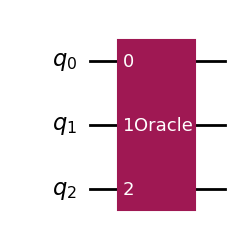

In [3]:
n = 2
case = 'balanced'

oracle_gate = Oracle(case, n)
qc = QuantumCircuit(n+1)
qc.append(oracle_gate, qc.qubits)
qc.draw('mpl', style='iqx')

In [4]:
def oracle_test(oracle, basis):
    n = oracle.n
    qc = QuantumCircuit(n+1, n+1)
    initial_state = np.array(basis) / np.linalg.norm(basis)
    qc.initialize(initial_state, range(n))
    qc.barrier()
    qc.append(oracle, qc.qubits)
    qc.measure(range(n+1), reversed(range(n+1)))
    return qc

In [5]:
qc = oracle_test(oracle_gate, [1, 0, 0, 0])

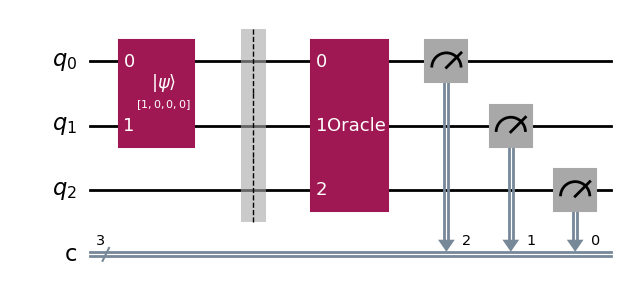

In [6]:
qc.draw('mpl', style='iqx')

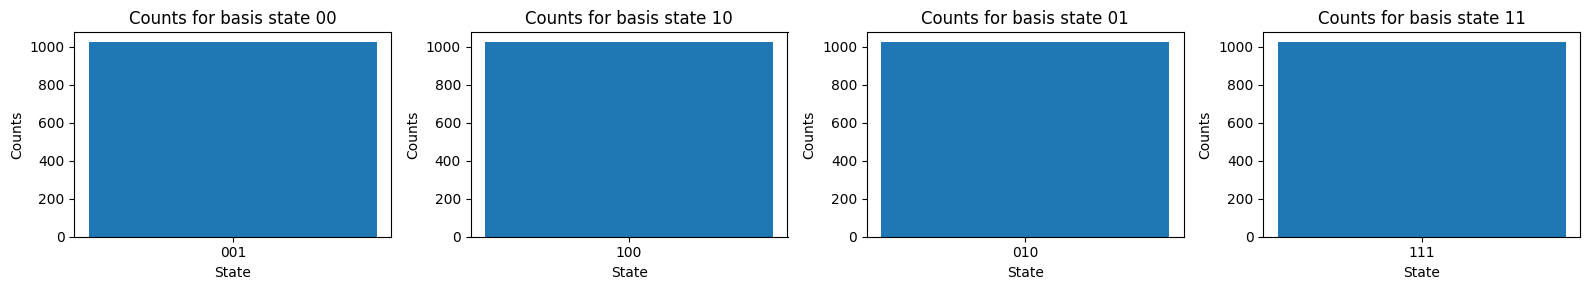

In [7]:
# Run the simulation
simulator = Aer.get_backend('qasm_simulator')

# States to be tested (z-basis)
states = ['00', '10', '01', '11'] # Caution: qiskit uses reversed bit order

# Convert the states to the computational basis
bases = []
for state in states:
    bases.append([1 if s == state else 0 for s in states])

# Run the simulation for each basis
counts = []
for basis in bases:
    qc = oracle_test(oracle_gate, basis)
    result = execute(qc, simulator).result()
    counts.append(result.get_counts(qc))

# Plot the results
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
for i in range(4):
    ax[i].bar(list(counts[i].keys()), list(counts[i].values()))
    ax[i].set_xlabel('State')
    ax[i].set_ylabel('Counts')
    ax[i].set_title(f'Counts for basis state {states[i]}')
plt.tight_layout()
plt.show()

## Deutsch-Jozsa Algorithm

In [8]:
def deutsch_jozsa(oracle):
    n = oracle.n
    qc = QuantumCircuit(n+1, n)
    qc.x(n)
    qc.barrier()
    qc.h(range(n+1))
    qc.append(oracle, qc.qubits)
    qc.h(range(n))
    qc.measure(range(n), reversed(range(n)))
    return qc

In [9]:
def run_dj(case, n):
    oracle_gate = Oracle(case, n)
    qc = deutsch_jozsa(oracle_gate)
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend).result()
    return result.get_counts(qc)

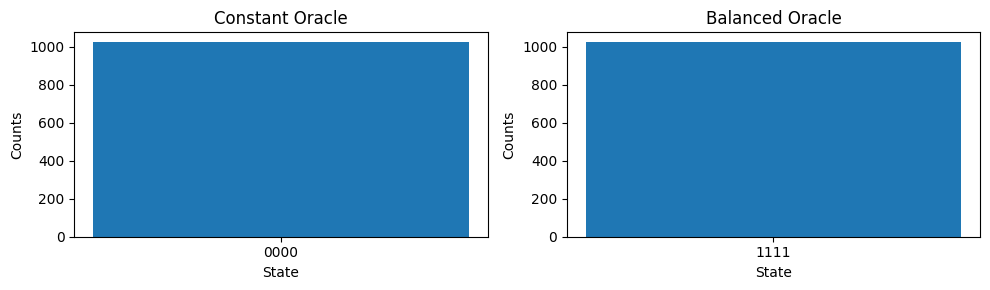

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].bar(list(run_dj('constant', 4).keys()), list(run_dj('constant', 4).values()))
ax[0].set_xlabel('State')
ax[0].set_ylabel('Counts')
ax[0].set_title('Constant Oracle')
ax[1].bar(list(run_dj('balanced', 4).keys()), list(run_dj('balanced', 4).values()))
ax[1].set_xlabel('State')
ax[1].set_ylabel('Counts')
ax[1].set_title('Balanced Oracle')
plt.tight_layout()
plt.show()

### For IBM-Q

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler

In [13]:
service = QiskitRuntimeService()
options = Options(optimization_level=1)
options.execution.shots = 1024

In [16]:
def run_dj(case, n):
    oracle_gate = Oracle(case, n)
    qc = deutsch_jozsa(oracle_gate)
    backend = service.get_backend('ibmq_qasm_simulator')
    sampler = Sampler(backend=backend, options=options)
    job = sampler.run(qc)
    return job.result()

In [17]:
c4 = run_dj('constant', 4)

In [19]:
b4 = run_dj('balanced', 4)

In [21]:
c4

SamplerResult(quasi_dists=[{0: 1.0}], metadata=[{'shots': 1024, 'circuit_metadata': {}}])

In [22]:
b4

SamplerResult(quasi_dists=[{15: 1.0}], metadata=[{'shots': 1024, 'circuit_metadata': {}}])

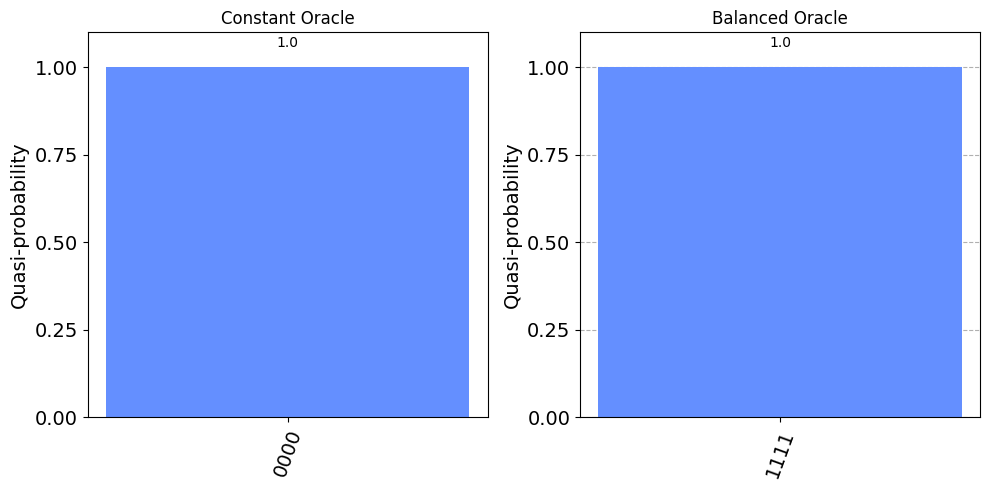

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_distribution(c4.quasi_dists[0].binary_probabilities(), ax=ax[0])
ax[0].set_title('Constant Oracle')
plot_distribution(b4.quasi_dists[0].binary_probabilities(), ax=ax[1])
ax[1].set_title('Balanced Oracle')
plt.tight_layout()
plt.show()

In [31]:
c10 = run_dj('constant', 10)
b10 = run_dj('balanced', 10)

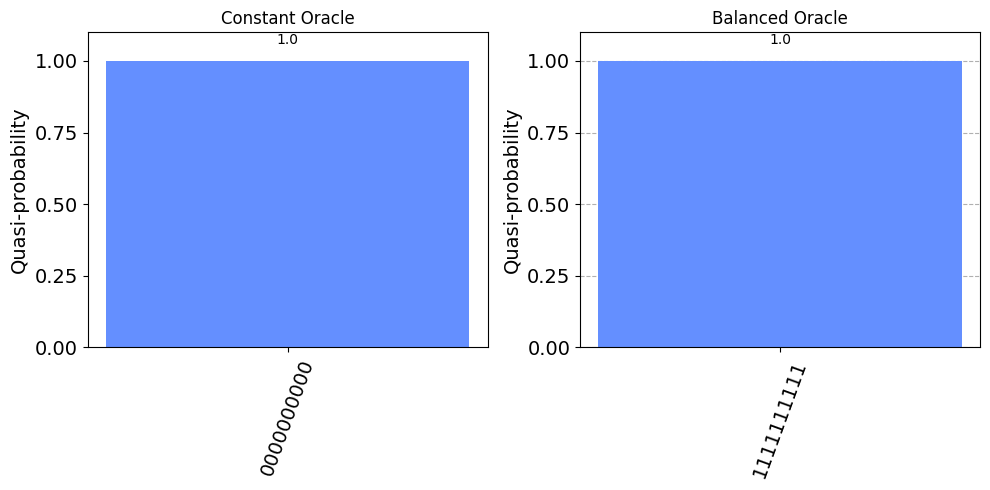

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_distribution(c10.quasi_dists[0].binary_probabilities(), ax=ax[0])
ax[0].set_title('Constant Oracle')
plot_distribution(b10.quasi_dists[0].binary_probabilities(), ax=ax[1])
ax[1].set_title('Balanced Oracle')
plt.tight_layout()
plt.show()